## **BTLD Input Shape setting**

데이터 불러오기

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
file = 'ch23_24_19_20_25.csv'
BTLDdata = pd.read_csv(file, encoding='cp949')
BTLDdata.isnull().any()

Date                             False
A23                              False
B23                              False
C23                              False
D23                              False
Unnamed: 5                        True
A24                              False
B24                              False
C24                              False
D24                              False
Unnamed: 10                       True
A19                              False
B19                              False
C19                              False
D19                              False
Unnamed: 15                       True
A20                              False
B20                              False
C20                              False
D20                              False
Unnamed: 20                       True
A25                              False
B25                              False
C25                              False
D25                              False
Unnamed: 25              

In [2]:
#plot 설정
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=15)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=15)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=15)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=15)  # 범례 폰트 크기
plt.rc('figure', titlesize=20) #제목


#채널별 데이터 추출
Rawdata=BTLDdata.set_index('Date')
ch23 = Rawdata.iloc[:, [0,1,2,3,25,26,27,28,29,30,31,32,33,34]]
ch24 = Rawdata.iloc[:,[5,6,7,8,25,26,27,28,29,30,31,32,33,34]]
ch19 = Rawdata.iloc[:,[10,11,12,13,25,26,27,28,29,30,31,32,33,34]]
ch20 = Rawdata.iloc[:,[15,16,17,18,25,26,27,28,29,30,31,32,33,34]]
ch25 = Rawdata.iloc[:,[20,21,22,23,25,26,27,28,29,30,31,32,33,34]]
#print(ch23.head(),ch24.head(),ch19.head(),ch20.head(),ch25.head())

#주파수 대역별 데이터 추출
A = Rawdata.iloc[:,[0,5,10,15,20,25,26,27,28,29,30,31,32,33,34]]
B = Rawdata.iloc[:,[1,6,11,16,21,25,26,27,28,29,30,31,32,33,34]]
C = Rawdata.iloc[:,[2,7,12,17,22,25,26,27,28,29,30,31,32,33,34]]
D = Rawdata.iloc[:,[3,8,13,18,23,25,26,27,28,29,30,31,32,33,34]]
#print(A.head(),B.head(),C.head(),D.head())

print('0-30kHz일때 채널 및 영향인자:', A.shape)
print('30-60kHz일때 채널 및 영향인자:', B.shape)
print('60-90kHz일때 채널 및 영향인자:', C.shape)
print('90-200kHz일때 채널 및 영향인자:', D.shape)

0-30kHz일때 채널 및 영향인자: (2832, 15)
30-60kHz일때 채널 및 영향인자: (2832, 15)
60-90kHz일때 채널 및 영향인자: (2832, 15)
90-200kHz일때 채널 및 영향인자: (2832, 15)


주파수 대역 설정

In [3]:
#예측하고자 하는 주파수 대역
df = A

#예측하고자하는 특정 채널에서의 해당 주파수
frequency=Rawdata.iloc[:,[0]]
# A=0, B=1, C=2, D=3

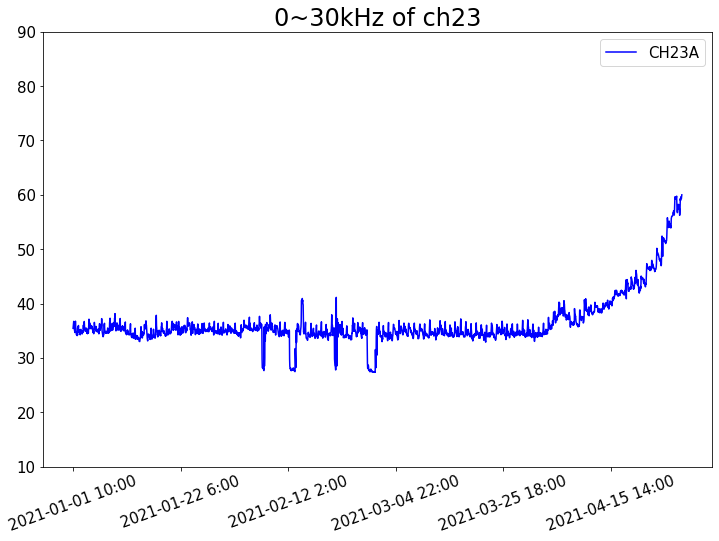

In [4]:
plt.plot(frequency, color='b', label='CH23A') #주파수에 따라 label 바꿔주기
plt.xticks([0,500, 1000, 1500, 2000, 2500])
plt.xticks(rotation=20)
plt.ylim(10,90)
plt.title("0~30kHz of ch23")
plt.legend()
plt.show()

정규화 이전의 그래프

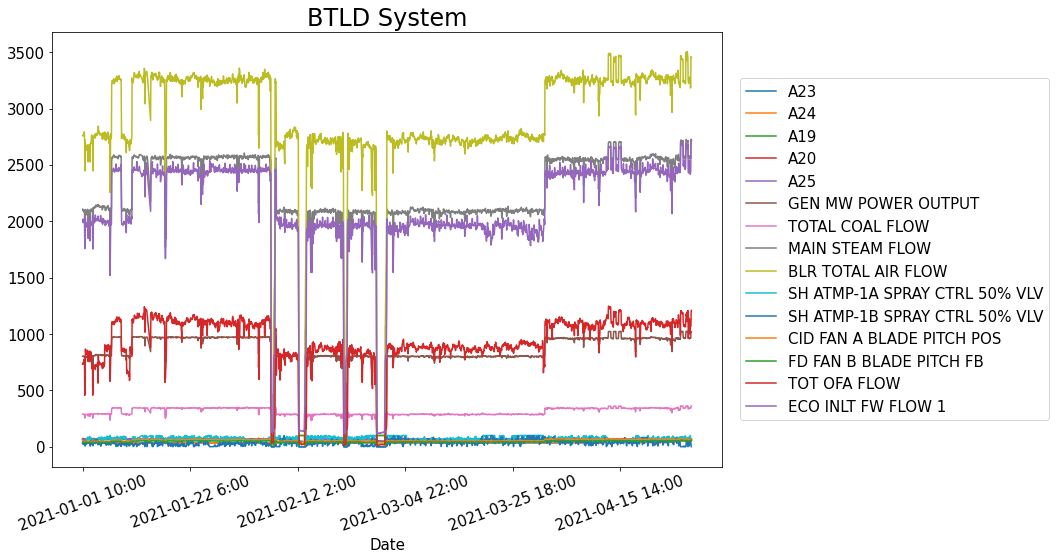

In [5]:
df.plot(subplots=False)
#plt.xticks(rotation=45)
plt.title("BTLD System")
plt.xticks(rotation=20)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

데이터 정규화(MinMaxScaler) 및 시각화

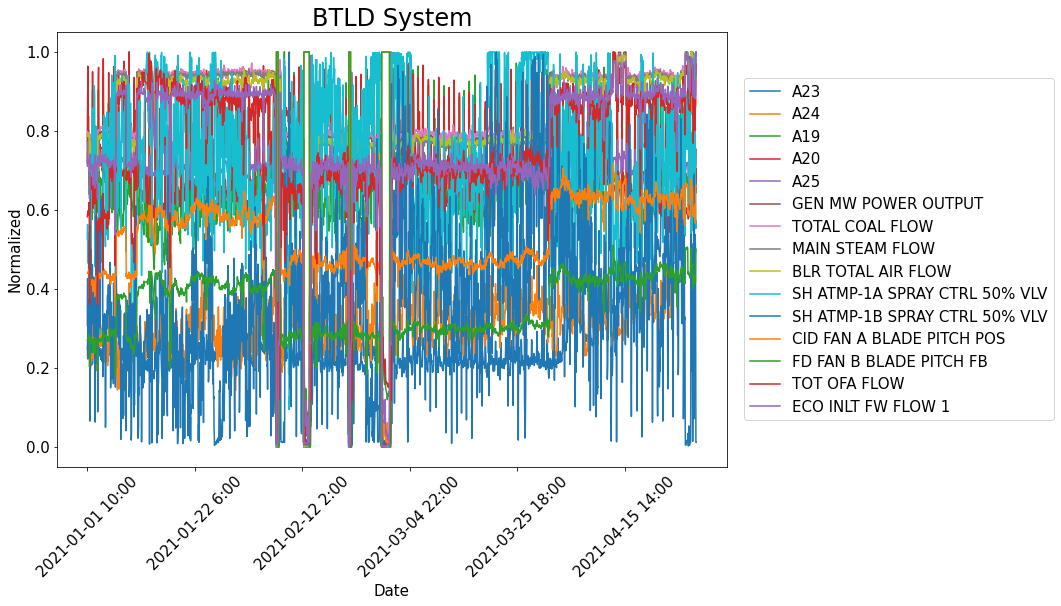

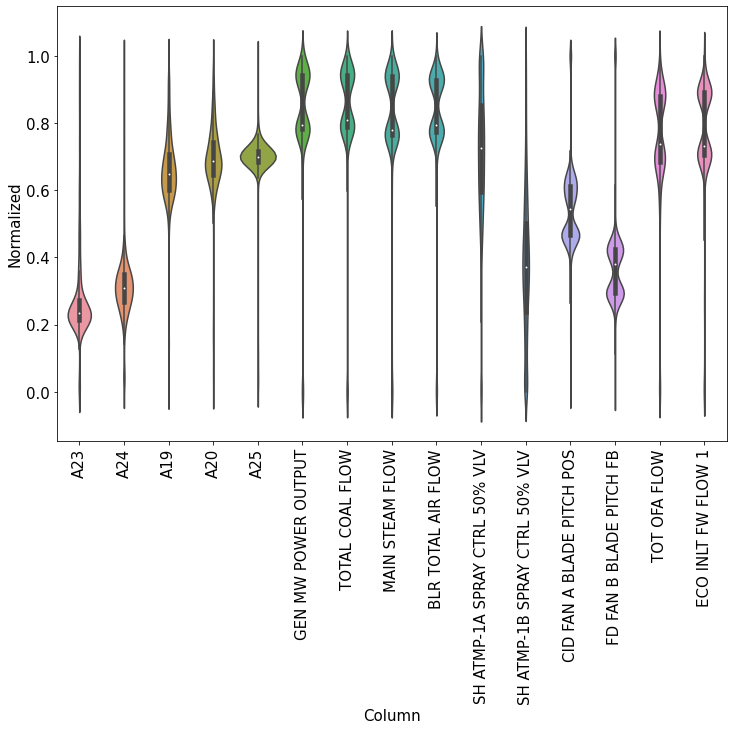

In [6]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

scaler = MinMaxScaler()
df_s = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_s)
df_scaled.columns=['A23','A24','A19','A20','A25','GEN MW POWER OUTPUT','TOTAL COAL FLOW','MAIN STEAM FLOW','BLR TOTAL AIR FLOW',
                   'SH ATMP-1A SPRAY CTRL 50% VLV','SH ATMP-1B SPRAY CTRL 50% VLV','CID FAN A BLADE PITCH POS',
                   'FD FAN B BLADE PITCH FB','TOT OFA FLOW','ECO INLT FW FLOW 1'] #주파수에 따라 label 바꿔주기
df_scaled.index=Rawdata.index

df_scaled.plot(subplots=False, title='BTLD System', ylabel='Normalized', xlabel='Date')
plt.xticks(rotation=45)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()

df_scaled_g = df_scaled.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=df_scaled_g)
_ = ax.set_xticklabels(df.keys(), rotation=90)

상관계수

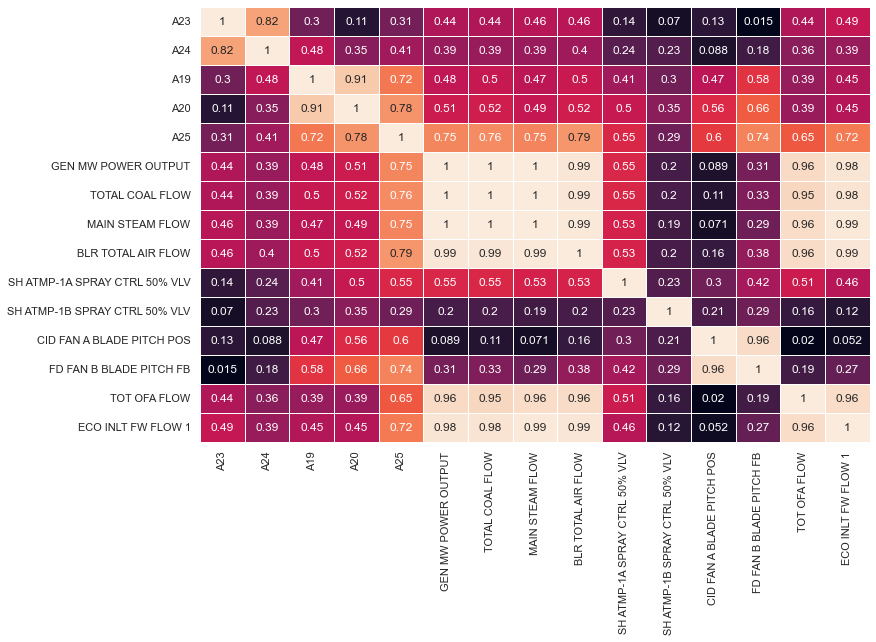

In [7]:
import seaborn as sns
df_scaled_corr=df_scaled.corr()
sns.set(font_scale=1)
sns.heatmap(df_scaled_corr.abs(), annot=True, cbar=False, linewidths=.5);
plt.show()

# 원도우 생성

-timesteps: 예측에 사용되는 과거 데이터 개수

-n_future: 예측하고자하는 데이터 개수

-과거 100개(timesteps)의 데이터를 가지고 앞으로의 1개(n_future) 데이터를 예측

-train : test = 70% : 30%

In [8]:
import numpy as np
df_scaled=np.array(df_scaled)

X = []
Y = []
n_future = 1 
timesteps = 100
for i in range(timesteps, len(df_scaled) - n_future +1):
  X.append(df_scaled[i - timesteps:i, 0:df_scaled.shape[1]]) 
  Y.append(df_scaled[i + n_future - 1:i + n_future, 0])
X, Y = np.array(X), np.array(Y)

X_len = len(X)
Y_len = len(Y)
trainX = X[0:int(X_len*0.7)]
trainY = Y[0:int(Y_len*0.7)]
testX = X[int(X_len*0.7):]
testY = Y[int(Y_len*0.7):]

print('X shape: ', X.shape)        
print('Y shape: ', Y.shape)        
print('trainX shape: ', trainX.shape) 
print('trainY shape: ', trainY.shape)
print('testX shape: ', testX.shape)  
print('testY shape: ', testY.shape)  

X shape:  (2732, 100, 15)
Y shape:  (2732, 1)
trainX shape:  (1912, 100, 15)
trainY shape:  (1912, 1)
testX shape:  (820, 100, 15)
testY shape:  (820, 1)


# **Loss find Moddel**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 64)           20480     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 32,929
Trainable params: 32,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
54/54 [==============================] - 8s 18ms/step - loss: 0.0496 - val_loss: 5.4660e-04
Epoch 2/200
54/54 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 6.2930e-04
Epoch 3/200
54/54 [=======================

54/54 [==============================] - 1s 10ms/step - loss: 3.9810e-04 - val_loss: 2.5959e-04
Epoch 69/200
54/54 [==============================] - 1s 10ms/step - loss: 4.3284e-04 - val_loss: 2.2046e-04
Epoch 70/200
54/54 [==============================] - 1s 10ms/step - loss: 3.7073e-04 - val_loss: 2.2213e-04
Epoch 71/200
54/54 [==============================] - 1s 10ms/step - loss: 3.9026e-04 - val_loss: 2.1223e-04
Epoch 72/200
54/54 [==============================] - 1s 9ms/step - loss: 4.2300e-04 - val_loss: 2.1914e-04
Epoch 73/200
54/54 [==============================] - 1s 10ms/step - loss: 4.0678e-04 - val_loss: 2.1539e-04
Epoch 74/200
54/54 [==============================] - 1s 10ms/step - loss: 3.9807e-04 - val_loss: 3.0977e-04
Epoch 75/200
54/54 [==============================] - 1s 9ms/step - loss: 4.2123e-04 - val_loss: 5.0541e-04
Epoch 76/200
54/54 [==============================] - 1s 9ms/step - loss: 4.1831e-04 - val_loss: 2.1411e-04
Epoch 77/200
54/54 [===============

54/54 [==============================] - 1s 9ms/step - loss: 3.0314e-04 - val_loss: 2.9854e-04
Epoch 144/200
54/54 [==============================] - 1s 9ms/step - loss: 2.8123e-04 - val_loss: 1.8476e-04
Epoch 145/200
54/54 [==============================] - 1s 10ms/step - loss: 2.8839e-04 - val_loss: 2.1621e-04
Epoch 146/200
54/54 [==============================] - 1s 10ms/step - loss: 2.8371e-04 - val_loss: 2.2841e-04
Epoch 147/200
54/54 [==============================] - 1s 10ms/step - loss: 2.8559e-04 - val_loss: 1.9872e-04
Epoch 148/200
54/54 [==============================] - 1s 10ms/step - loss: 2.9371e-04 - val_loss: 1.9993e-04
Epoch 149/200
54/54 [==============================] - 1s 10ms/step - loss: 2.8844e-04 - val_loss: 2.2898e-04
Epoch 150/200
54/54 [==============================] - 1s 10ms/step - loss: 2.9747e-04 - val_loss: 1.9678e-04
Epoch 151/200
54/54 [==============================] - 1s 10ms/step - loss: 2.8535e-04 - val_loss: 2.3236e-04
Epoch 152/200
54/54 [=====

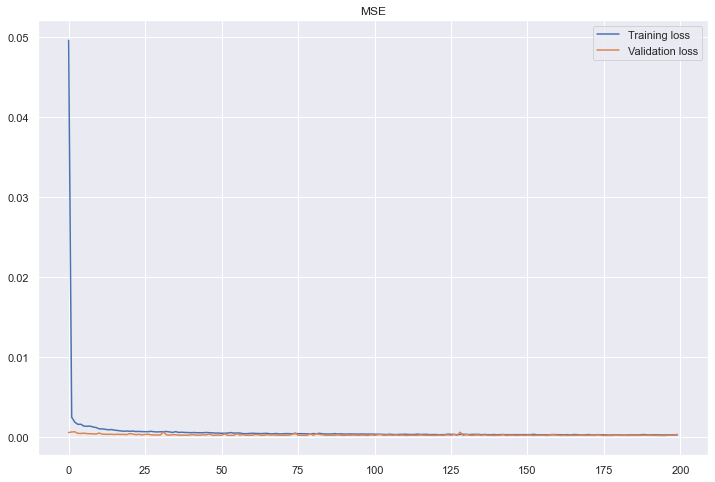

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf


'''
[Modeling]
(64개 출력 / tanh / (100X15)입력 / 다음 layer에 LSTM 네트워크 받는지 여부)
(32개 출력 / tanh / 다음 layer에 LSTM 네트워크 받는지 여부)
(강제로 20%의 가중치를 초기화)
(1개 출력)'''
from tensorflow.keras import layers
LossFindModel = Sequential([
  layers.LSTM(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
  layers.LSTM(32, activation='tanh', return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(trainY.shape[1])
])
LossFindModel.summary()


#최적화 옵션 선택
opt1 = tf.keras.optimizers.Adam(learning_rate = 0.01, decay = 1e-7, beta_1=0.9, beta_2=0.999, epsilon=None,amsgrad=False) 
                                #학습률 / 학습률의 감소율 / beta_1(기본설정값) / beta_2(기본설정값) / epsilon(기본설정값) / amsgrad(기본설정값)
opt2 = tf.keras.optimizers.SGD(learning_rate = 0.01, decay = 1e-7, momentum = 0.9, nesterov = False)
                                #학습률 / 학습률의 감소율 / 경사강하법에 관성 부여하여 로컬 미니멈에 도달했을 때 탈출하도록 / 모멘텀작동여부
opt3 = tf.keras.optimizers.RMSprop(learning_rate=0.01, decay = 1e-7, rho=0.9, epsilon=None)
                                #학습률 / 학습률의 감소율 / rho(기본설정값) / epsilon(기본설정값) 


#모델 compiling
LossFindModel.compile(loss = 'MSE', optimizer = opt1) #MSE오차 / opt1 / 정확도


#epoch stop 설정(epoch가 너무 많으면 오버피팅되고, 너무 적으면 언더피팅되므로)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='auto') 
#validation data의 오차 모니터링 / 성능이 증가하지 않는 epoch 20번 허용 / validation data의 오차를 최소화 시킬지 최대화 시킬지 자동으로 선택


#모델 fitting
LossFindHistory = LossFindModel.fit(trainX, trainY, epochs=200, batch_size=32, validation_split=0.1, verbose=1)


#오차 그래프
plt.plot(LossFindHistory.history['loss'], label='Training loss')
plt.plot(LossFindHistory.history['val_loss'], label='Validation loss')
plt.title("MSE")
plt.legend()

In [13]:
LossFind_val_loss = LossFindHistory.history['val_loss']
print('val_loss 최소값 Index: ', LossFind_val_loss.index(min(LossFind_val_loss)))
LossFind_val_loss = pd.DataFrame(LossFind_val_loss)
print('val_loss 최소값: ', LossFind_val_loss.min())

val_loss 최소값 Index:  193
val_loss 최소값:  0    0.000171
dtype: float64


# **LSTM Model**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 64)           20480     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 32,929
Trainable params: 32,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
54/54 [==============================] - 2s 17ms/step - loss: 0.0866 - val_loss: 6.1950e-04
Epoch 2/50
54/54 [==============================] - 1s 10ms/step - loss: 0.0022 - val_loss: 5.5884e-04
Epoch 3/50
54/54 [========================

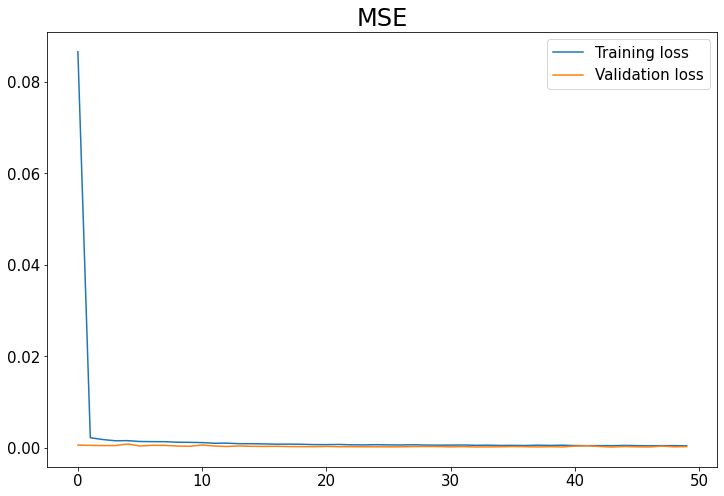

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf


'''
[Modeling]
(64개 출력 / tanh / (100X15)입력 / 다음 layer에 LSTM 네트워크 받는지 여부)
(32개 출력 / tanh / 다음 layer에 LSTM 네트워크 받는지 여부)
(강제로 20%의 가중치를 초기화)
(1개 출력)'''
from tensorflow.keras import layers
model = Sequential([
  layers.LSTM(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
  layers.LSTM(32, activation='tanh', return_sequences=False),
  layers.Dropout(0.2),
  layers.Dense(trainY.shape[1])
])
model.summary()


#최적화 옵션 선택
opt1 = tf.keras.optimizers.Adam(learning_rate = 0.01, decay = 1e-7, beta_1=0.9, beta_2=0.999, epsilon=None,amsgrad=False) 
                                #학습률 / 학습률의 감소율 / beta_1(기본설정값) / beta_2(기본설정값) / epsilon(기본설정값) / amsgrad(기본설정값)
opt2 = tf.keras.optimizers.SGD(learning_rate = 0.01, decay = 1e-7, momentum = 0.9, nesterov = False)
                                #학습률 / 학습률의 감소율 / 경사강하법에 관성 부여하여 로컬 미니멈에 도달했을 때 탈출하도록 / 모멘텀작동여부
opt3 = tf.keras.optimizers.RMSprop(learning_rate=0.01, decay = 1e-7, rho=0.9, epsilon=None)
                                #학습률 / 학습률의 감소율 / rho(기본설정값) / epsilon(기본설정값) 


#모델 compiling
model.compile(loss = 'MSE', optimizer = opt1) #MSE오차 / opt1 / 정확도


#epoch stop 설정(epoch가 너무 많으면 오버피팅되고, 너무 적으면 언더피팅되므로)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='auto') 
#validation data의 오차 모니터링 / 성능이 증가하지 않는 epoch 20번 허용 / validation data의 오차를 최소화 시킬지 최대화 시킬지 자동으로 선택


#모델 fitting
history = model.fit(trainX, trainY, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


#오차 그래프
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("MSE")
plt.legend()

In [15]:
val_loss = history.history['val_loss']
print('val_loss 최소값 Index: ', val_loss.index(min(val_loss)))
val_loss = pd.DataFrame(val_loss)
print('val_loss 최소값: ', val_loss.min())

val_loss 최소값 Index:  43
val_loss 최소값:  0    0.000197
dtype: float64


In [2]:
model.save("LSTMmodel-A23.h5")
from tensorflow.keras.models import load_model
model = load_model("LSTMmodel-A23.h5")

NameError: name 'model' is not defined

# **test, prediction 비교**

In [20]:
forecast = model.predict(testX)
forecast_copies = np.repeat(forecast, df_scaled.shape[1], axis=-1)

predicted_data = scaler.inverse_transform(forecast_copies)[:testX.shape[0]-1,0]

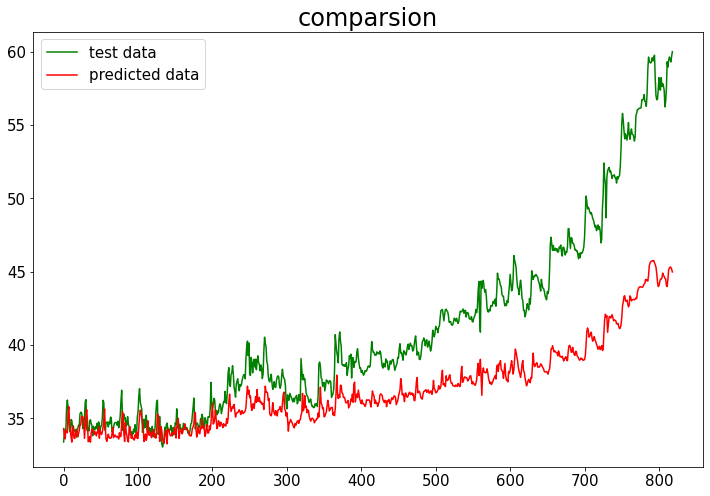

In [21]:
df = scaler.inverse_transform(df_scaled)

test_data = df[int(Y_len*0.7+(timesteps+n_future)):,0]

plt.plot(test_data, label='test data', color='g')

plt.plot(predicted_data, label='predicted data', color='r')
plt.title('comparsion')
plt.legend()

# **error 확인**

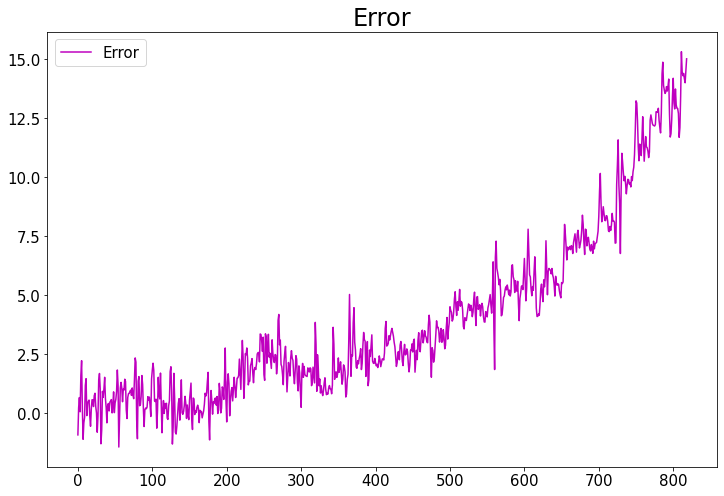

Total Error:  3266.1573565586414
Max Error:  15.320332600498055


In [22]:
error = test_data-predicted_data
plt.plot(error, label='Error', color='m')
plt.title('Error')
plt.legend()
plt.show()
totalerror = sum(abs(error))
#plt.plot(totalerror)
print('Total Error: ', totalerror)
print('Max Error: ', abs(error).max())

Total Scale Error:  [262.32264439]


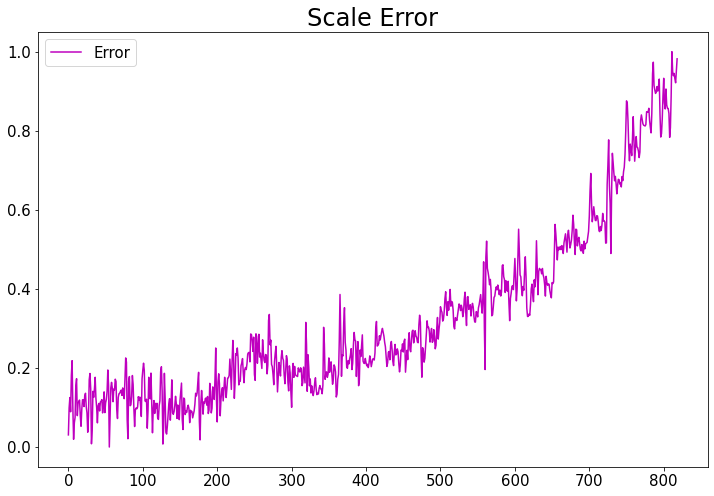

In [23]:
scaler1 = MinMaxScaler()
error = error.reshape(-1,1)
error_s = scaler1.fit_transform(error)
error_scaled = pd.DataFrame(error_s)
plt.plot(error_scaled, label='Error', color='m')
plt.title('Scale Error')
plt.legend()

error_scaled = np.array(error_scaled)
totalerror_s = sum(abs(error_scaled))
print('Total Scale Error: ', totalerror_s)

# **Train, Test, Prediction 확인**

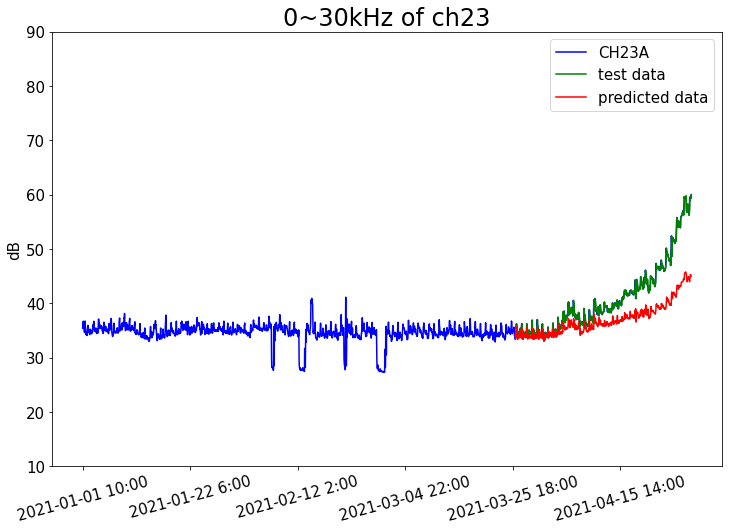

In [24]:
plt.plot(frequency, color='b', label='CH23A')

plt.plot(np.arange(trainX.shape[0]+timesteps+n_future+1,trainX.shape[0]+testX.shape[0]+timesteps+n_future), test_data, label='test data', color='g')

plt.plot(np.arange(trainX.shape[0]+timesteps+n_future,trainX.shape[0]+testX.shape[0]+timesteps), predicted_data, 'r', label='predicted data')

plt.title('0~30kHz of ch23')
plt.ylabel('dB')
plt.xticks([0,500,1000,1500,2000,2500])
plt.ylim(10,90)
plt.xticks(rotation=15)
plt.legend()
plt.show()